# Supernova cadence metric

This metric is an estimate of the redshift limit z of a faint [(x1,color) = (-2.0,0.2)] supernovae. Depending on Signal-to-Noise thresholds (defined by the user), mean cadences and mean five-sigma depth values (from simulation), z is corresponding to the detection limit. This metric reflects cadences and m5 dependencies on supernova detection.

Input parameters
- band
- Signal-To-Noise ratio (SNR per band): use as detection thresholds (typical values given below)
- mag_range: magnitude range considered
- dt_range : cadence range (in days-1) for the study
- zmin, zmax: min and mad redshifts for the study
- Li_files : list of npy files with light curves
- mag_to_flux : list of npy files with mag to flux conversion

This metric may be run yearly, per season or using the complete survey.


## Imports

In [1]:
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import sqlite3
import numpy as np
from sn_metrics.sn_cadence_metric import SNCadenceMetric
import sn_plotter_metrics.cadencePlot as sn_plot

## DB file choice

In [2]:
dbName = 'descddf_v1.5_10yrs.db'
dbFile = '/home/philippe/LSST/DB_Files/{}'.format(dbName)
opsimdb = db.OpsimDatabase(dbFile)
version = opsimdb.opsimVersion
#propinfo, proptags = opsimdb.fetchPropInfo()
#print('proptags and propinfo', proptags, propinfo)
runLength = opsimdb.fetchRunLength()

Cannot access Config table to retrieve runLength; using default 10 years


## Field choice (DD or WFD)¶

In [3]:
fieldtype='WFD' #fieldtype: DD or WFD
bands = 'r' 

propinfo, proptags = opsimdb.fetchPropInfo()
print('proptags and propinfo', proptags, propinfo)

sqlconstraint = opsimdb.createSQLWhere(fieldtype, proptags)

if fieldtype == 'DD':
    SNR = dict(zip('griz', [25., 25., 30., 35.]))  # SNR for DD
    mag_range = [23., 27.5]  # DD mag range
    dt_range = [0.5, 25.]  # DD dt range
    coadd = True
    zmin = 0.4
    zmax = 0.7
if fieldtype == 'WFD':
    SNR = dict(zip('griz', [30., 40., 30., 20.]))  # SNR for WFD
    mag_range = [21., 25.5]  # WFD mag range
    dt_range = [0.5, 30.]  # WFD dt range
    coadd = False
    zmin = 0.1
    zmax = 0.6
    
Li_files = ['../reference_files/Li_SNCosmo_-2.0_0.2.npy']
mag_to_flux_files = ['../reference_files/Mag_to_Flux_SNCosmo.npy']
names_ref = ['SNCosmo']

No proposal table available - no proposalIds have been assigned.
proptags and propinfo {} {}
No WFD proposals found


## Define slicer

In [4]:
slicer = slicers.HealpixSlicer(nside=64)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


### Run for selected years

In [5]:
bundleList= []
names = []
yearDates = list(range(0, int(round(365 * runLength)) + 365, 365))
for band in bands: #Loop on the bands
    #sql_i = sqlconstraint+' AND '
    sql_i = ''
    sql_i += 'filter = "%s"' % (band) #sql constraint on the band
    
    for season in range(1,2):
        metric = SNCadenceMetric(coadd=coadd)
            
        sql_y = sql_i + ' AND night > %i AND night <= %i' % (
                    yearDates[np.max([0,season-2])], yearDates[np.min([9,season + 2])]) #sql constraint on the year 
        bundleList.append(metricBundles.MetricBundle(
            metric, slicer, sql_y, runName= dbName))
        names.append('{}_{}'.format(band,season))
print(len(bundleList))
bdict = dict(zip(names, bundleList))

1


In [6]:
outDir = '{}_Cadence'.format(dbName)
#resultsDb = db.ResultsDb(outDir=outDir)
#bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
#bgroup = metricBundles.MetricBundleGroup(bundleDict, opsimdb, outDir=outDir, resultsDb=resultsDb)
#resu = bgroup.runAll()

resultsDb = db.ResultsDb(outDir=outDir)
mbg = metricBundles.MetricBundleGroup(bdict, opsimdb,
                                          outDir=outDir, resultsDb=resultsDb)

result = mbg.runAll()

Querying database SummaryAllProps with constraint filter = "r" AND night > 0 AND night <= 1095 for columns ['numExposures', 'fiveSigmaDepth', 'visitTime', 'filter', 'fieldRA', 'fieldDec', 'observationStartMJD', 'observationId', 'night', 'visitExposureTime']
Found 136219 visits
Running:  ['r_1']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


### Imports for display

In [14]:
%matplotlib inline
import pandas as pd

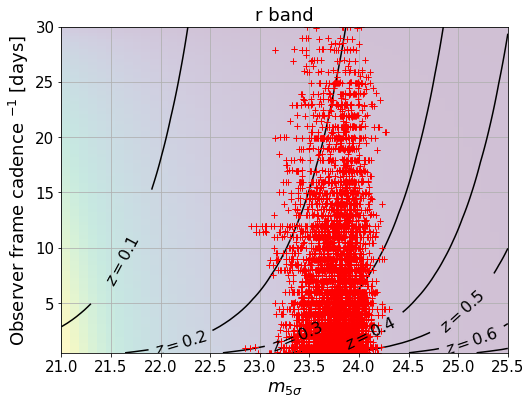

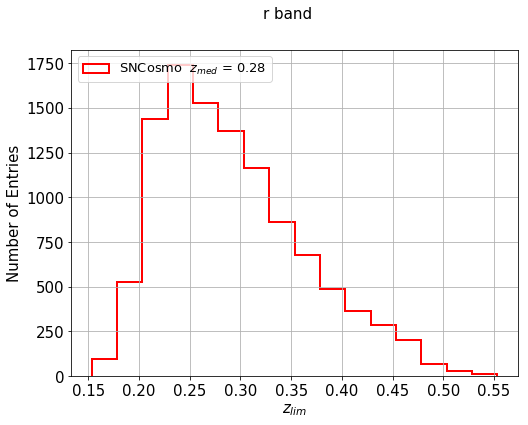

In [22]:
for key, val in bdict.items():
    band = key.split('_')[0]
    metValues = val.metricValues[~val.metricValues.mask]
    res = pd.DataFrame()
    for io,val in enumerate(metValues):
        res = pd.concat((res,val))
        if io > 5000:
            break
        """
        print(val.columns)
        if res is None:
            res = val
        else:
            print(val)
            res = np.concatenate((res, val))
            break
        """
    #res = np.unique(res)
    #print(res)
    sn_plot.plotCadence(band,Li_files, mag_to_flux_files,
                        SNR[band],res.to_records(index=False),
                        names_ref,
                        mag_range=mag_range, dt_range=dt_range,dbName=dbName.split('.')[0])